In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from datetime import timedelta
from matplotlib.ticker import MultipleLocator


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor

from sklearn import model_selection, preprocessing, metrics, tree
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import IsolationForest, BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import make_scorer ,confusion_matrix, mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection



%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

seed_val = 42

In [9]:
# constants
DATA_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/raw_data/'
SUBMISSION_PATH = '/kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions'

In [10]:
# loading the data
train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

# reseting index
#train = train.set_index('ID')
#test = test.set_index('ID')

## Pre processing

In [4]:
# X0 groups
train['eng1_X0_group'] = train[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 0 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj', 'v', 'ao', 'aw']
                                       else 3 if x['X0'] in ['c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else 4, axis=1)

test['eng1_X0_group'] = test[['X0']].apply(lambda x: 0 if x['X0'] in ['bc', 'az']
                                       else 1 if x['X0']  in ['ac', 'am', 'l', 'b', 'aq', 'u', 'ad', 'e', 
                                                                 'al', 's', 'n', 'y', 't', 'ai', 'k', 'f', 'z', 
                                                                 'o', 'ba', 'm', 'q']
                                       else 2 if x['X0'] in ['d', 'ay', 'h', 'aj']
                                       else 3 if x['X0'] in ['v', 'ao', 'aw', 'c', 'ax', 'x', 'j', 'w', 'i',
                                                                'ak', 'g', 'at', 'ab', 'af', 'r', 'as', 'a', 'ap',
                                                                'au', 'aa']
                                       else 4, axis=1)



#X5 groups
train['eng1_X5_groups'] = train[['X5']].apply(lambda x: 0 if x['X5'] in ['h', 'x']
                                         else 1 if x['X5'] in ['y', 'g', 'o'] 
                                         else 2 if x['X5'] in ['aa', 'r', 'ah', 'w', 'k', 'ac', 'v', 'q', 'l',
                                                                  'j', 'p', 'i', 'd', 'ae', 'ag', 's', 'n', 'm',
                                                                  'af', 'ab', 'ad', 'c', 'f']
                                         else 3 if x['X5'] in ['u']
                                         else 4, axis=1)

test['eng1_X5_groups'] = test[['X5']].apply(lambda x: 0 if x['X5'] in ['h', 'x']
                                         else 1 if x['X5'] in ['y', 'g', 'o'] 
                                         else 2 if x['X5'] in ['aa', 'r', 'ah', 'w', 'k', 'ac', 'v', 'q', 'l',
                                                                  'j', 'p', 'i', 'd', 'ae', 'ag', 's', 'n', 'm',
                                                                  'af', 'ab', 'ad', 'c', 'f']
                                         else 3 if x['X5'] in ['u']
                                         else 4, axis=1)

In [5]:
#X0_group version 2
train['eng1_X0_group_2'] = train[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else 4, axis=1)

test['eng1_X0_group_2'] = test[['X127', 'X118', 'X238']].apply(lambda x: 0 if(x['X127']==0 and x['X118']==0 and x['X238']==0)
                                                             else 1 if(x['X127']==1)
                                                             else 2 if(x['X127']==0 and x['X118']==0 and x['X238']==1)
                                                             else 3 if(x['X127']==0 and x['X118']==1)
                                                             else 4, axis=1)

In [6]:
train['eng1_bin_sum'] = train.iloc[:,10:378].apply(lambda x: np.sum(x), axis=1 )
test['eng1_bin_sum'] = test.iloc[:,9:377].apply(lambda x: np.sum(x), axis=1 )

### Data Cleaning

In [7]:
cols_drop = []
cols_drop.append(['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']) # zero-var cols
#cols_drop.append(['X5'])
for i, col in enumerate(cols_drop):
    train = train.drop(col, 1)
    test = test.drop(col, 1)

In [9]:
# keep_cols = list(train.T.drop_duplicates().T.columns)
# train = train[keep_cols]

# keep_cols.remove('y')
# test = test[keep_cols]

In [10]:
# keeping only values < 265 to remove the 1 outlier at y=265.32; ID=1770
#train = train[train['y']<265]

# train['eng1_oulier'] = train[['eng1_X0_group_2', 'y']].apply(lambda x: 1 if ((x['eng1_X0_group_2']==0) and (x['y'] <80))
#                                                              else 1 if ((x['eng1_X0_group_2']==1) and (x['y'] <96))
#                                                              else 1 if ((x['eng1_X0_group_2']==2) and (x['y'] <103))
#                                                              else 1 if ((x['eng1_X0_group_2']==3) and (x['y'] <266))
#                                                              else 0, axis=1)

# test['eng1_oulier'] = test[['eng1_X0_group_2', 'y']].apply(lambda x: 1 if ((x['eng1_X0_group_2']==0) and (x['y'] <80))
#                                                              else 1 if ((x['eng1_X0_group_2']==1) and (x['y'] <96))
#                                                              else 1 if ((x['eng1_X0_group_2']==2) and (x['y'] <103))
#                                                              else 1 if ((x['eng1_X0_group_2']==3) and (x['y'] <266))
#                                                              else 0, axis=1)

### Splitting and Traning 

In [11]:
# train['pred1_group_y'] = train[['y']].apply(lambda x: 0 if (x['y']<80)
#                                            else 1 if (x['y']>80 and x['y']<96)
#                                            else 2 if (x['y']>96 and x['y']<103)
#                                            else 3 if (x['y']>103)
#                                            else -1, axis=1)

In [12]:
# target_col = ['pred1_group_y']
# ignore_cols = ['y']
# ignore_cols.append(target_col[0])
# train_cols = [col for col in train.columns if col not in ignore_cols]

# train_x = train[train_cols]
# train_y = train[target_col]
# test_x = test[train_cols]

In [13]:
# print('--- encoding columns from train and test datasets ---')
# for f in train_x.columns:
#     if train_x[f].dtype=='object':
#         print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
#         train_x[f] = lbl.transform(list(train_x[f].values))
#         test_x[f] = lbl.transform(list(test_x[f].values))

In [14]:
# trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=42)
# print('trn_x.shape:', trn_x.shape)
# print('val_x.shape:', val_x.shape)
# print('trn_y.shape:', trn_y.shape)
# print('val_y.shape:', val_y.shape)
# trn_y = trn_y.values.ravel()
# val_y = val_y.values.ravel()

In [15]:
# def xgb_accuracy(y_pred, dtrain):
#     y_true = dtrain.get_label()
#     accuracy_sklearn = accuracy_score(y_true, y_pred)
#     accuracy_sklearn = accuracy_sklearn * -1.0
#     return 'error', accuracy_sklearn

# estimator = [{
#         'objective': "multi:softprob",
#         'max_depth': 5,
#         'n_estimators': 100,
#         'learning_rate': 0.05,
#         'nthread': 12,
#         'seed': seed_val,
#         'subsample': 0.7,
#         'colsample_bytree': 0.7,
#         'min_child_weight': 1,
# #        'reg_alpha': 2,
# #        'reg_lambda': 1,
#         'gamma':50,
#         'silent': True
#     }]

# scores = cross_val_score(XGBClassifier(**estimator[0]), trn_x, trn_y, cv=10, scoring='accuracy')
# print('cv_scores:', scores)
# print('mean trn k-fold scores:', np.mean(scores))
# model = XGBClassifier(**estimator[0]).fit(trn_x, trn_y, verbose=False, eval_metric=xgb_accuracy)
# print('val score:', accuracy_score(val_y, model.predict(val_x)))

In [16]:
# confusion_matrix(val_y, model.predict(val_x) )

In [17]:
# test['pred1_group_y'] = model.predict(test_x)

### Traning

In [18]:
target_col = ['y']
ignore_cols = []
ignore_cols.append(target_col[0])
train_cols = [col for col in train.columns if col not in ignore_cols]

train_x = train[train_cols]
train_y = train[target_col]
test_x = test[train_cols]

print('--- encoding columns from train and test datasets ---')
for f in train_x.columns:
    if train_x[f].dtype=='object':
        print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
        train_x[f] = lbl.transform(list(train_x[f].values))
        test_x[f] = lbl.transform(list(test_x[f].values))

--- encoding columns from train and test datasets ---
encoding column: X0 (original dtype: object )
encoding column: X1 (original dtype: object )
encoding column: X2 (original dtype: object )
encoding column: X3 (original dtype: object )
encoding column: X4 (original dtype: object )
encoding column: X5 (original dtype: object )
encoding column: X6 (original dtype: object )
encoding column: X8 (original dtype: object )


In [19]:
# from sklearn.decomposition import PCA, FastICA
# from sklearn.random_projection import GaussianRandomProjection
# from sklearn.random_projection import SparseRandomProjection
# n_comp = 10

# # PCA
# pca = PCA(n_components=n_comp, random_state=42)
# pca2_results_train = pca.fit_transform(train_x)
# pca2_results_test = pca.transform(test_x)

# # ICA
# ica = FastICA(n_components=n_comp, random_state=42)
# ica2_results_train = ica.fit_transform(train_x)
# ica2_results_test = ica.transform(test_x)

# # GRP
# grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
# grp_results_train = grp.fit_transform(train_x)
# grp_results_test = grp.transform(test_x)

# # SRP
# srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
# srp_results_train = srp.fit_transform(train_x)
# srp_results_test = srp.transform(test_x)


# # Append decomposition components to datasets
# for i in range(1, n_comp+1):
#     train_x['pca_' + str(i)] = pca2_results_train[:,i-1]
#     test_x['pca_' + str(i)] = pca2_results_test[:, i-1]
    
#     train_x['ica_' + str(i)] = ica2_results_train[:,i-1]
#     test_x['ica_' + str(i)] = ica2_results_test[:, i-1]
    
#     train_x['grp_' + str(i)] = grp_results_train[:,i-1]
#     test_x['grp_' + str(i)] = grp_results_test[:, i-1]
    
#     train_x['srp_' + str(i)] = srp_results_train[:,i-1]
#     test_x['srp_' + str(i)] = srp_results_test[:, i-1]

In [20]:
def xgb_r2(y_pred, dtrain):
    y_true = dtrain.get_label()
    r2_sklearn = r2_score(y_true, y_pred)
    r2_sklearn = r2_sklearn * -1.0
    return 'error', r2_sklearn

In [21]:
def oof_regression_predictor(train_x, train_y, test_x, n_folds, estimators, pred_cols, 
                             train_eval_metric, compare_eval_metric):
    
    start_time = time.time()
                                              
    # initializing blending data frames
    train_blend = train_x
    test_blend = test_x

    # Note: StratifiedKFold splits into roughly 66% train 33% test  
    skf = list(StratifiedKFold(train_y.values.ravel(), n_folds, random_state=seed_val))
    
    dataset_blend_train = np.zeros((train_x.shape[0], len(estimators)))
    dataset_blend_test = np.zeros((test_x.shape[0], len(estimators)))
    
    for j, estimator in enumerate(estimators):
        dataset_blend_test_j = np.zeros((test_x.shape[0], len(skf)))
        for i, (train, test) in enumerate(skf):
            trn_x = train_x.iloc[train, :] 
            trn_y = train_y.iloc[train].values.ravel()
            val_x = train_x.iloc[test, :] 
            val_y = train_y.iloc[test].values.ravel()

            # if xgb
            if ( 'dict' in str(type(estimator))):
                eval_set = [(trn_x, trn_y),(val_x, val_y)]
                model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
                                                eval_metric=train_eval_metric)
            
            # else sklean
            else:          
                model = estimator.fit(trn_x, trn_y)
                
            pred_train = model.predict(val_x)
            dataset_blend_train[test, j] = pred_train
            print('fold:', i+1, '/', n_folds, '; estimator:',  j+1, '/', len(estimators), ' -> oof cv score:', 
                  compare_eval_metric(val_y, pred_train) )

            pred_test = model.predict(test_x)
            dataset_blend_test_j[:, i] = pred_test
    
        dataset_blend_test[:, j] = np.mean(dataset_blend_test_j, axis=1)
        
        
    print('--- comparing models ---')
    # comparing models
    for i in range(dataset_blend_train.shape[1]):
        print('model', i+1, ':', compare_eval_metric(train_y, dataset_blend_train[:,i]))
        
    for i, j in enumerate(estimators):
        train_blend[pred_cols[i]] = dataset_blend_train[:,i]
        test_blend[pred_cols[i]] = dataset_blend_test[:,i]
    
    end_time = time.time()
    print("Total Time usage: " + str(timedelta(seconds=int(round(end_time - start_time)))))
    return train_blend, test_blend, model

In [22]:
# Predictors
estimators = [{
        'objective': "reg:linear",
        'max_depth': 5,
        'n_estimators': 100,
        'learning_rate': 0.05,
        'nthread': 12,
        'seed': seed_val,
        'subsample': 0.7,
         'colsample_bytree': 0.7,
        'min_child_weight': 1,
        'gamma':10,
        'silent': True
    }]

pred_cols = ['pred1_xgb_y_pred']

train_blend, test_blend, model = oof_regression_predictor(train_x, 
                                                     train_y, 
                                                     test_x, 
                                                     n_folds = 5, 
                                                     estimators=estimators, 
                                                     pred_cols = pred_cols,  
                                                     train_eval_metric=xgb_r2,
                                                     compare_eval_metric=r2_score)

/kaggle/dev/jovan/mercedes-benz-greener-manufacturing/venv-mercedes/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


fold: 1 / 5 ; estimator: 1 / 1  -> oof cv score: 0.468915112857
fold: 2 / 5 ; estimator: 1 / 1  -> oof cv score: 0.630197647259
fold: 3 / 5 ; estimator: 1 / 1  -> oof cv score: 0.693849596458
fold: 4 / 5 ; estimator: 1 / 1  -> oof cv score: 0.776331410685
fold: 5 / 5 ; estimator: 1 / 1  -> oof cv score: 0.412593655132
--- comparing models ---
model 1 : 0.518873720245
Total Time usage: 0:00:18


In [23]:
#(0.468915112857+0.630197647259+0.693849596458+0.776331410685+0.412593655132)/5

In [80]:
# trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=seed_val)

In [81]:
# estimator = [{
#         'objective': "reg:linear",
#         'max_depth': 5,
#         'n_estimators': 100,
#         'learning_rate': 0.05,
#         'nthread': 12,
#         'seed': seed_val,
#         'subsample': 0.7,
#          'colsample_bytree': 0.7,
#         'min_child_weight': 1,
# #         'reg_alpha': 10,
# #         'reg_lambda': 1,
#         'gamma':10,
#         'silent': True
#     }]








# scores = cross_val_score(XGBRegressor(**estimator[0]), trn_x, trn_y, cv=10, scoring='r2')
# print('cv_scores:', scores)
# print('mean trn k-fold scores:', np.mean(scores))
# model_1 = XGBRegressor(**estimator[0]).fit(trn_x, trn_y, verbose=False, eval_metric=xgb_r2)
# print('val score:', r2_score(val_y, model_1.predict(val_x)))

In [22]:
post_analysis = train_x.copy()
post_analysis['y_pred'] = train_x[pred_cols[0]]
post_analysis['y_true'] = train_y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

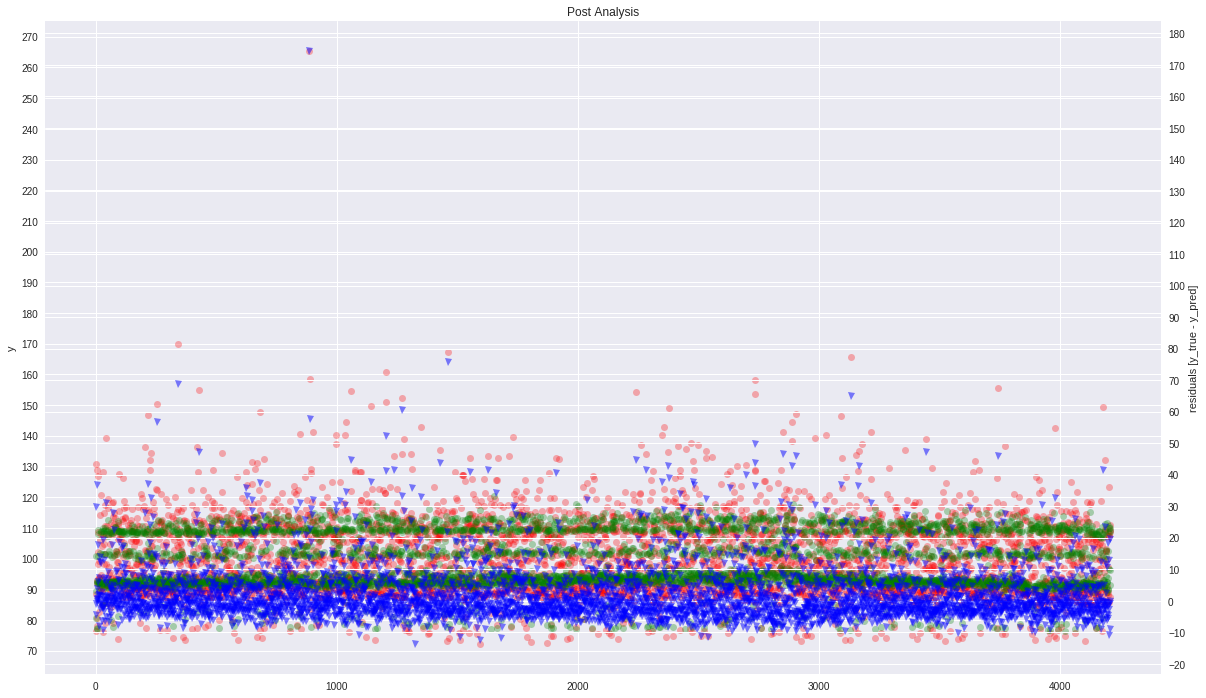

In [23]:
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

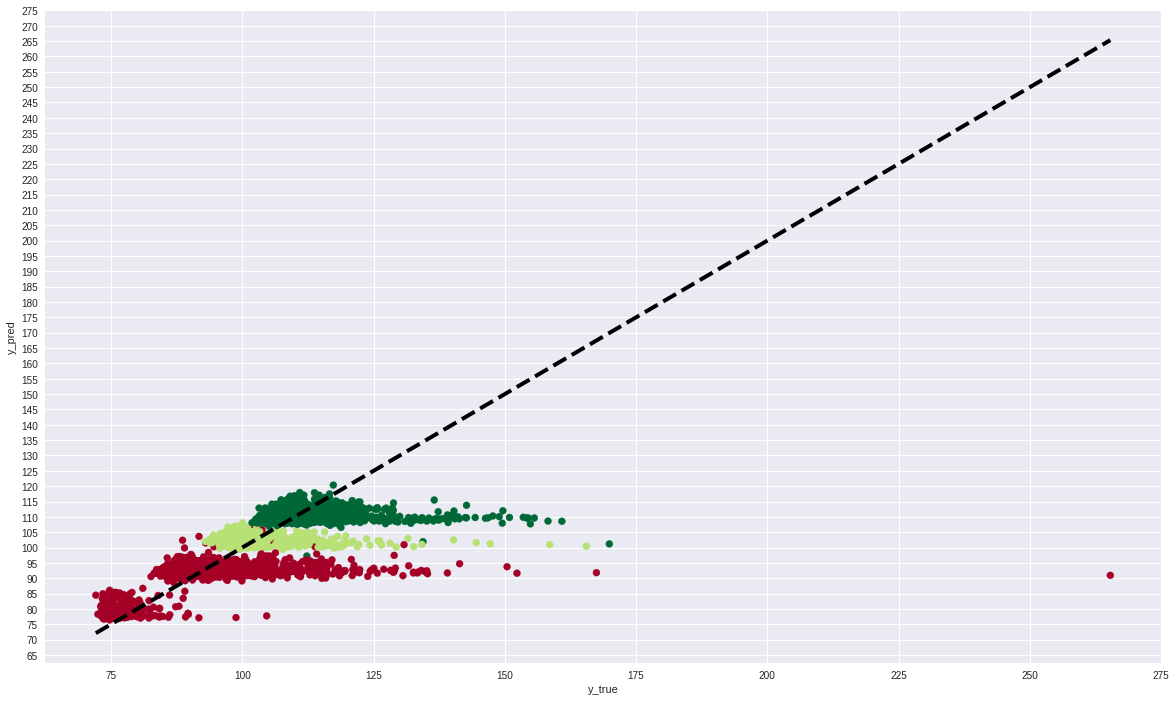

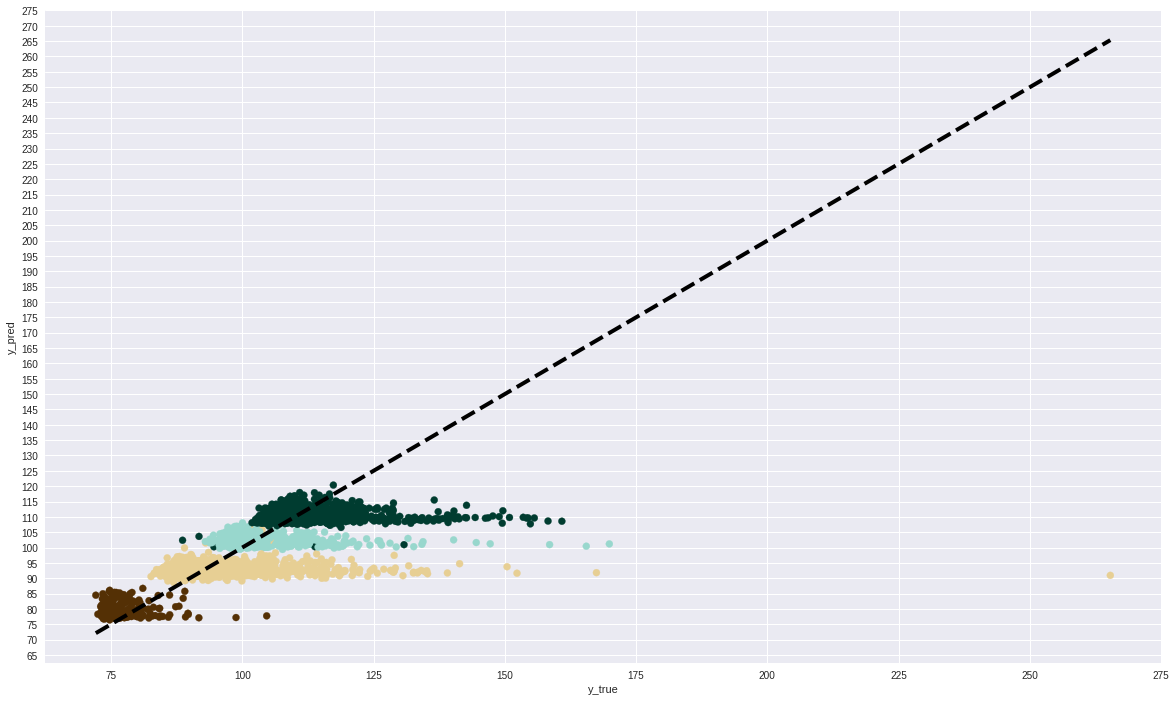

In [24]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter( post_analysis['y_true'],  post_analysis['y_pred'], c=post_analysis['eng1_X0_group'], cmap=plt.cm.RdYlGn)
plt.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()


majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
plt.scatter( post_analysis['y_true'],  post_analysis['y_pred'], c=post_analysis['eng1_X0_group_2'], cmap=plt.cm.BrBG)
plt.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()

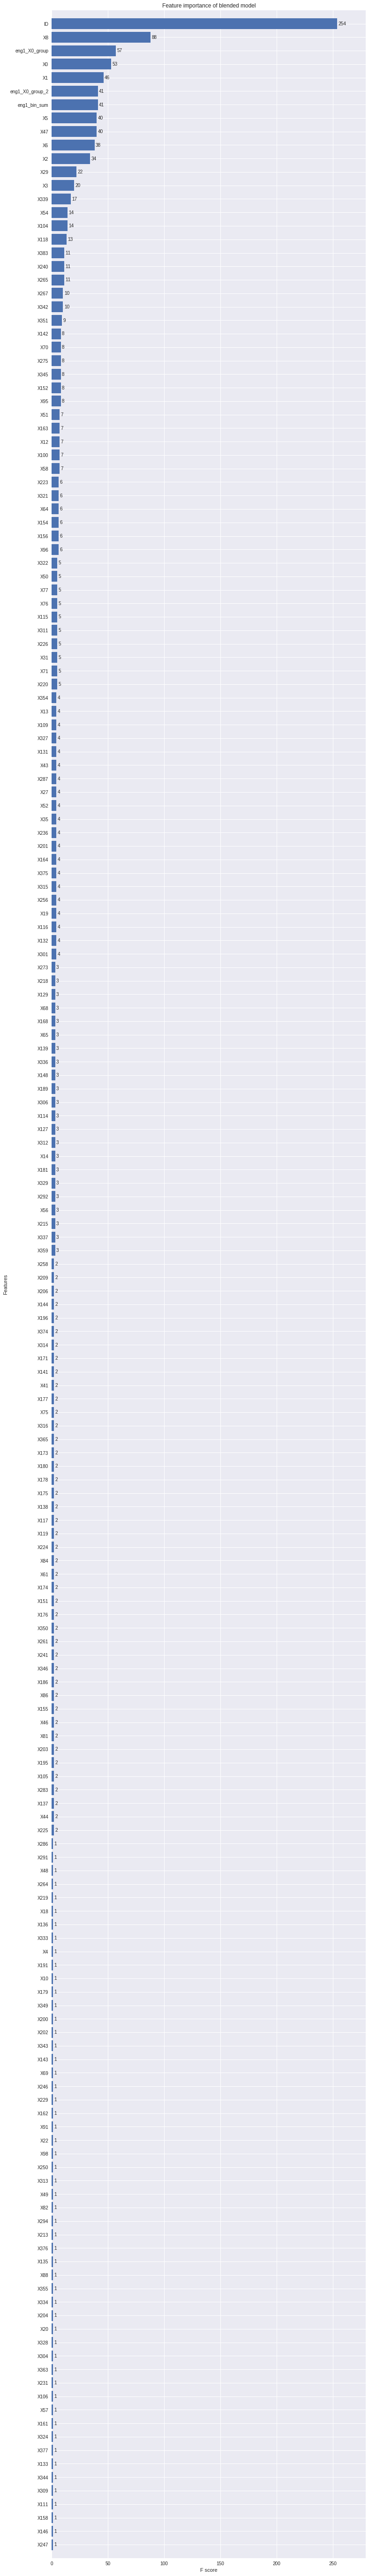

In [25]:
fig, ax = plt.subplots(figsize=(12,100))

xgb.plot_importance(model, height=0.8, ax=ax, title='Feature importance of blended model')

### Trying to predict high values

In [69]:
trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=seed_val)

In [70]:
# trn_x = trn_x[(trn_x['eng1_X0_group_2']==3)]
# val_x = val_x[(val_x['eng1_X0_group_2']==3)]
#trn_x['y_pred_model_1'] = model_1.predict(trn_x)
#val_x['y_pred_model_1'] = model_1.predict(val_x)
# trn_x = trn_x[trn_x['y_pred_model_1'] > 105]
# val_x = val_x[val_x['y_pred_model_1'] > 105]

# clf = IsolationForest()
# model = clf.fit(trn_x)
# trn_x['is_outlier'] = model.predict(trn_x)
# #val_x['is_outlier'] = model.predict(val_x)

trn_x['y_val'] = trn_y
trn_x = trn_x[
              ((trn_x['eng1_X0_group_2']==0) & (trn_x['y_val'] <80)) |
              ((trn_x['eng1_X0_group_2']==1) & (trn_x['y_val'] <96)) |
              ((trn_x['eng1_X0_group_2']==2) & (trn_x['y_val'] <110))|
              ((trn_x['eng1_X0_group_2']==3) & (trn_x['y_val'] <266))
]
trn_x = trn_x.drop('y_val', axis=1)
trn_y = trn_y.loc[trn_x.index.values]

In [195]:
estimator = [{
        'objective': "reg:linear",
        'max_depth': 15,
        'n_estimators': 1000,
        'learning_rate': 0.05,
        'nthread': 12,
        'seed': seed_val,
        'subsample': 0.7,
         'colsample_bytree': 0.7,
        'min_child_weight': 1,
#         'reg_alpha': 10,
#         'reg_lambda': 1,
        'gamma':10,
        'silent': True
    }]


scores = cross_val_score(XGBRegressor(**estimator[0]), trn_x, trn_y, cv=10, scoring='r2')
print('cv_scores:', scores)
print('mean trn k-fold scores:', np.mean(scores))
model_2 = XGBRegressor(**estimator[0]).fit(trn_x, trn_y, verbose=False, eval_metric=xgb_r2)
print('val score:', r2_score(val_y, model_2.predict(val_x)))

cv_scores: [ 0.72790275  0.81833575  0.77521529  0.77569189  0.81298293  0.80323624
  0.7636355   0.80150213  0.73900268  0.78052371]
mean trn k-fold scores: 0.779802888214
val score: 0.514648475474


In [196]:
post_analysis = val_x.copy()
post_analysis['y_pred'] = model_2.predict(val_x)
post_analysis['y_true'] = val_y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

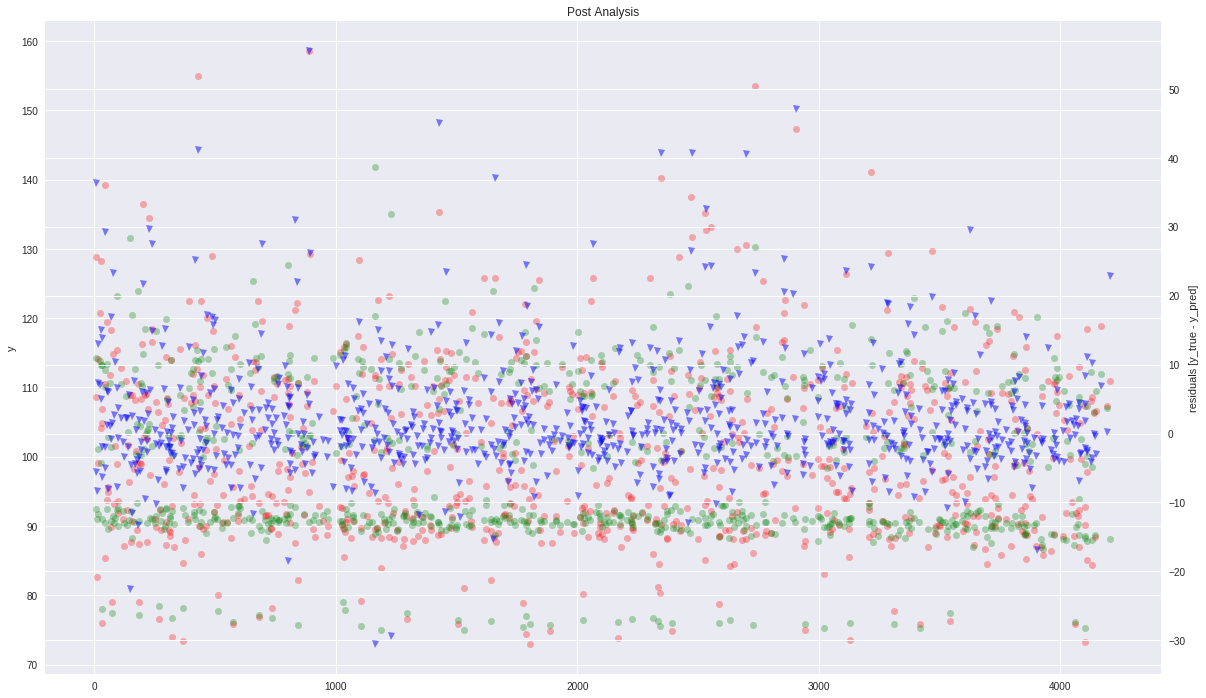

In [197]:
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

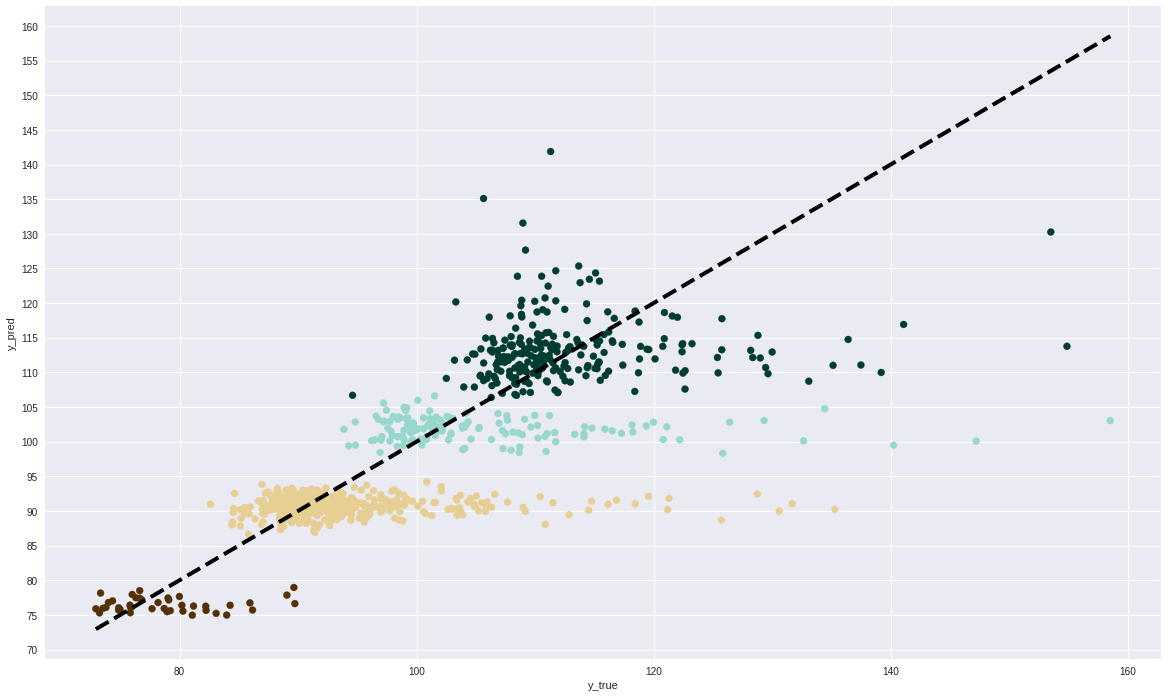

In [198]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter( post_analysis['y_true'],  post_analysis['y_pred'], c=post_analysis['eng1_X0_group_2'], cmap=plt.cm.BrBG)
ax.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()

### Ensembling

In [183]:
trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x, train_y, test_size=0.20, random_state=seed_val)

In [184]:
trn_x['y_pred_model_1'] = model_1.predict(trn_x[train_cols])
trn_x['y_pred_model_2'] = model_2.predict(trn_x[train_cols])

val_x['y_pred_model_1'] = model_1.predict(val_x[train_cols])
val_x['y_pred_model_2'] = model_2.predict(val_x[train_cols])


test_x['y_pred_model_1'] = model_1.predict(test_x[train_cols])
test_x['y_pred_model_2'] = model_2.predict(test_x[train_cols])

In [185]:
# def stacking_regressor(train_x, train_y, test_x, n_folds, estimators, train_eval_metric, 
#                        compare_eval_metric, blending, blend_eval_metric, pred_cols, blend_val_size):
    
#     start_time = time.time()
                           
#     print('--- encoding columns from train and test datasets ---')
#     for f in train_x.columns:
#         if train_x[f].dtype=='object':
#             print('encoding column:', f, '(original dtype:', train_x[f].dtype, ')')
#             lbl = preprocessing.LabelEncoder()
#             lbl.fit(list(set(train_x[f].values)| set(test_x[f].values))) 
#             train_x[f] = lbl.transform(list(train_x[f].values))
#             test_x[f] = lbl.transform(list(test_x[f].values))
                   
#     # initializing blending data frames
#     train_x_blend = train_x
#     test_x_blend = test_x
#     train_y_blend = train_y.values.ravel()

#     # Note: StratifiedKFold splits into roughly 66% train 33% test  
#     skf = list(StratifiedKFold(train_y.values.ravel(), n_folds, random_state=seed_val))
    
    
#     dataset_blend_train = np.zeros((train_x.shape[0], len(estimators)))
#     dataset_blend_test = np.zeros((test_x.shape[0], len(estimators)))
    
#     for j, estimator in enumerate(estimators):
#         dataset_blend_test_j = np.zeros((test_x.shape[0], len(skf)))
#         for i, (train, test) in enumerate(skf):
#             print('fold:', i+1, '/', n_folds, '; estimator:',  j+1, '/', len(estimators))
#             trn_x = train_x.iloc[train, :] 
#             trn_y = train_y.iloc[train].values.ravel()
#             val_x = train_x.iloc[test, :] 
#             val_y = train_y.iloc[test].values.ravel()

#             # if xgb
#             if ( 'dict' in str(type(estimator))):
#                 eval_set = [(trn_x, trn_y),(val_x, val_y)]
#                 model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
#                                                 eval_metric=train_eval_metric)
            
#             # else sklean
#             else:          
#                 model = estimator.fit(trn_x, trn_y)
                
#             pred_train = model.predict(val_x)
#             dataset_blend_train[test, j] = pred_train

#             pred_test = model.predict(test_x)
#             dataset_blend_test_j[:, i] = pred_test
    
#         dataset_blend_test[:, j] = np.mean(dataset_blend_test_j, axis=1)
        
        
#     print('--- comparing models ---')
#     # comparing models
#     for i in range(dataset_blend_train.shape[1]):
#         print('model', i+1, ':', compare_eval_metric(train_y, dataset_blend_train[:,i]))
    
#     # initializing test_y
#     test_y = model.predict(test_x)
#     blended_model = model
#     if blending:
#         print('--- blending ---')
        
#         for i, j in enumerate(estimators):
#             train_x_blend[pred_cols[i]] = dataset_blend_train[:,i]
#             test_x_blend[pred_cols[i]] = dataset_blend_test[:,i]
        
        
#         trn_x, val_x, trn_y, val_y = model_selection.train_test_split(train_x_blend, train_y_blend, 
#                                                                       test_size=blend_val_size, 
#                                                                       random_state=seed_val)
       
#         estimator = estimators[0]
#         eval_set =[(trn_x, trn_y), (val_x, val_y)]
#         model = XGBRegressor(**estimator).fit(trn_x, trn_y, eval_set=eval_set, verbose=False, 
#                                               eval_metric=blend_eval_metric)
#         blended_model = model
#         test_y = model.predict(test_x_blend)
#         val_pred_y = model.predict(val_x)
#         print('blended model:', compare_eval_metric(val_y, val_pred_y))
    
#     end_time = time.time()
#     print("Total Time usage: " + str(timedelta(seconds=int(round(end_time - start_time)))))
#     return dataset_blend_train, test_y, blended_model

In [186]:
# # Predictors
# estimators = [{
#         'objective': "reg:linear",
#         'max_depth': 5,
#         'n_estimators': 100,
#         'learning_rate': 0.05,
#         'nthread': 12,
#         'seed': seed_val,
#         'subsample': 0.7,
#          'colsample_bytree': 0.7,
#         'min_child_weight': 1,
# #         'reg_alpha': 10,
# #         'reg_lambda': 1,
#         'gamma':10,
#         'silent': True
#     },
#      RandomForestRegressor(n_estimators=10, n_jobs=-1,  random_state=seed_val),
#      ExtraTreesRegressor(n_estimators=10, n_jobs=-1, random_state=seed_val),
#      GradientBoostingRegressor(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50, random_state=seed_val)]

# pred_cols = ['pred1_xgb_y_pred', 
#              'pred1_rf_y_pred', 
#              'pred1_et_y_pred',
#              'pred1_gb_y_pred']

# # stacking 
# dataset_blend_train, test_y, blended_model = stacking_regressor(train_x, 
#                                                                  train_y, 
#                                                                  test_x, 
#                                                                  n_folds = 5, 
#                                                                  estimators=estimators, 
#                                                                  train_eval_metric=xgb_r2,
#                                                                  compare_eval_metric=r2_score,
#                                                                  blending=True,
#                                                                  blend_eval_metric=xgb_r2,
#                                                                  pred_cols = pred_cols,
#                                                                  blend_val_size=0.33)

In [189]:
enet = ElasticNet(l1_ratio=1)
scores = cross_val_score(enet, trn_x, trn_y, cv=10, scoring='r2')
print('cv_scores:', scores)
print('mean trn k-fold scores:', np.mean(scores))
model_final = enet.fit(trn_x, trn_y)
print('val score:', r2_score(val_y, model_final.predict(val_x)))

cv_scores: [ 0.68197454  0.44101457  0.68635526  0.79208229  0.67255769  0.76578146
  0.72837653  0.76903832  0.78104884  0.73397856]
mean trn k-fold scores: 0.705220806423
val score: 0.575212264163


In [190]:
post_analysis = val_x.copy()
post_analysis['y_pred'] = model_final.predict(val_x)
post_analysis['y_true'] = val_y
post_analysis['residuals'] = post_analysis[['y_pred', 'y_true']].apply(lambda x: x['y_true'] - x['y_pred'], axis=1)

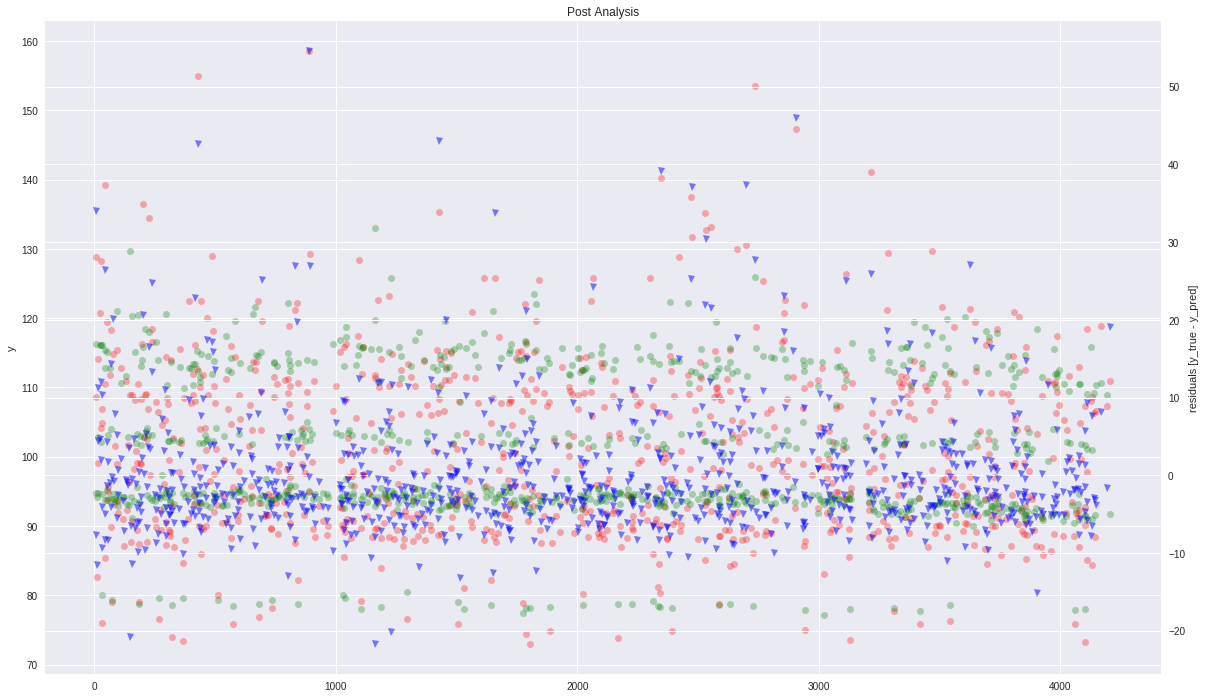

In [191]:
fig, ax1 = plt.subplots(figsize=(20,12))
ax2 = ax1.twinx()
plt.title('Post Analysis')
ax1.set_ylabel('y')
ax2.set_ylabel('residuals [y_true - y_pred]')
plt.xlabel('user_id')
ax1.plot(post_analysis.index.values, post_analysis['y_true'],'ro', alpha=0.30)
ax1.plot(post_analysis.index.values, post_analysis['y_pred'],'go', alpha=0.30)
ax2.plot(post_analysis.index.values, post_analysis['residuals'],'bv', alpha=0.50)
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(10))
plt.show()

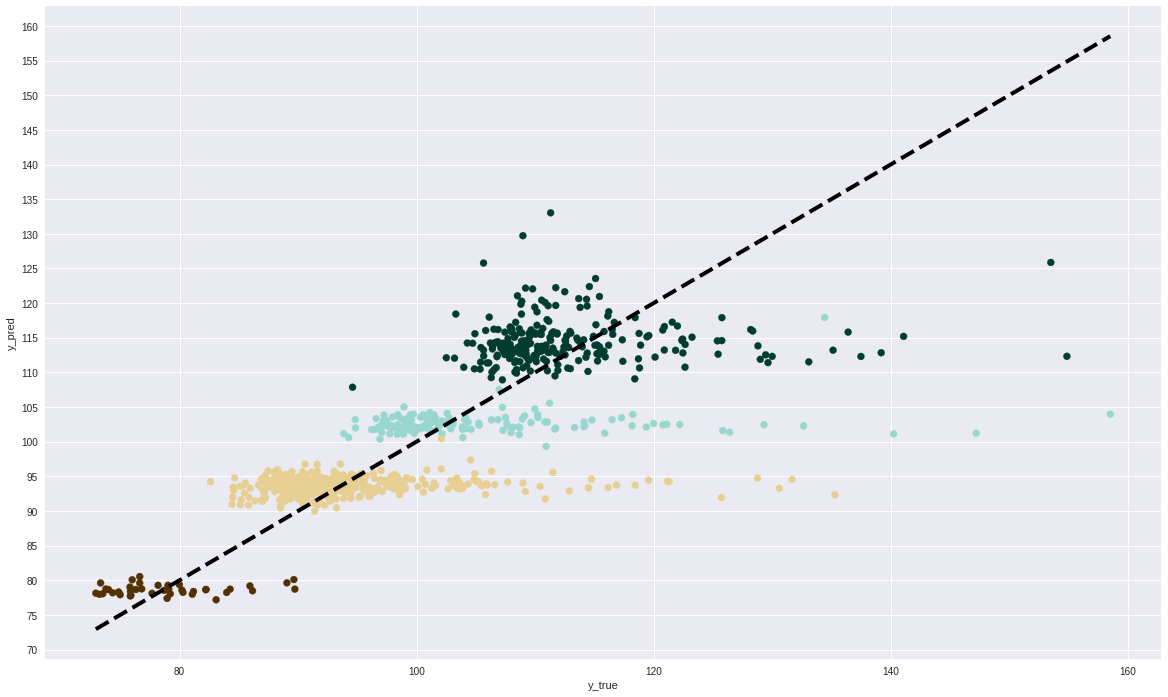

In [192]:
majorLocator = MultipleLocator(5)
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter( post_analysis['y_true'],  post_analysis['y_pred'], c=post_analysis['eng1_X0_group_2'], cmap=plt.cm.BrBG)
ax.plot([ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 
        [ post_analysis['y_true'].min(),  post_analysis['y_true'].max()], 'k--', lw=4)
ax.yaxis.set_major_locator(majorLocator)
ax.set_xlabel('y_true')
ax.set_ylabel('y_pred')
plt.show()

### Submission

In [28]:
# def generate_submission_file(output_path, test_x, model, team_name):
#     test_x['y'] = model.predict(test_x)
#     test_x = test_x.reset_index()
#     test_x = test_x[['ID', 'y']]
    
    
#     # Preparing to output
#     timestamp = str(int(time.time()))
#     filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
#     test_x.to_csv(filename, index=False)
#     print('output filename:', filename)
    
def generate_submission_file(output_path, test_x, team_name):
    test_x['y'] = test_x[pred_cols[0]]
    test_x = test_x[['ID', 'y']]
            
    # Preparing to output
    timestamp = str(int(time.time()))
    filename = output_path + '/submission-' + team_name + '-' + timestamp + ".csv"
    test_x.to_csv(filename, index=False)
    print('output filename:', filename)

In [29]:
team_name = 'jsardinha'
generate_submission_file(SUBMISSION_PATH, test_x, team_name)

output filename: /kaggle/dev/mercedes-benz-greener-manufacturing-data/submissions/submission-jsardinha-1498541384.csv
